In [2]:
!pip install optuna plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.2 MB/s eta 0:00:00


[I 2025-09-10 00:48:00,191] A new study created in memory with name: no-name-195a7dde-923e-4081-b6b5-3c13de6ecf7a
[I 2025-09-10 00:48:01,976] Trial 0 finished with value: -0.21393387275757644 and parameters: {'n_estimators': 348, 'max_depth': 3, 'learning_rate': 0.020772837213633787, 'subsample': 0.6332306139178757, 'colsample_bytree': 0.7658762855158013, 'min_child_weight': 8, 'gamma': 2.3712355091946486}. Best is trial 0 with value: -0.21393387275757644.
[I 2025-09-10 00:48:02,612] Trial 1 finished with value: -0.21936664192906014 and parameters: {'n_estimators': 548, 'max_depth': 10, 'learning_rate': 0.19635408528385123, 'subsample': 0.8854517858892896, 'colsample_bytree': 0.8532449668385302, 'min_child_weight': 4, 'gamma': 1.9453301820467157}. Best is trial 0 with value: -0.21393387275757644.
[I 2025-09-10 00:48:03,259] Trial 2 finished with value: -0.2180523386036946 and parameters: {'n_estimators': 673, 'max_depth': 5, 'learning_rate': 0.028290145083982858, 'subsample': 0.7643282

Best Params: {'n_estimators': 412, 'max_depth': 7, 'learning_rate': 0.03474182055187491, 'subsample': 0.7314785626463544, 'colsample_bytree': 0.79031136263413, 'min_child_weight': 8, 'gamma': 0.009027386320950015}
Best R2: 0.7230045612873652
Test R2: 0.8012, RMSE: 210.34, MAE: 139.57


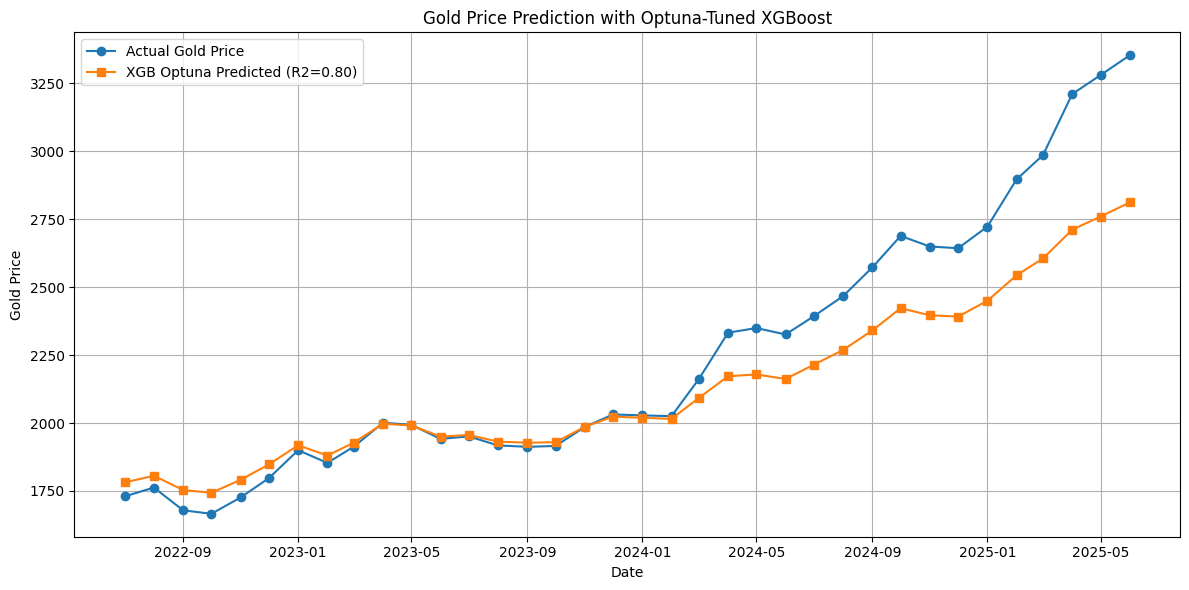

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from xgboost import XGBRegressor
# ==============================
# 1. 데이터 준비
# ==============================
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)
# Feature Engineering
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter
df['time_index'] = np.arange(len(df))
df['gold_lag1'] = df['Gold_Price'].shift(1)
df['gold_lag3'] = df['Gold_Price'].shift(3)
df['gold_lag6'] = df['Gold_Price'].shift(6)
df['gold_roll3'] = df['Gold_Price'].rolling(3).mean()
df['gold_vol3'] = df['Gold_Price'].rolling(3).std()
df['gold_roll6'] = df['Gold_Price'].rolling(6).mean()
df['gold_return'] = df['Gold_Price'].pct_change()
df['m2_growth'] = df['US_M2_Money_Supply'].pct_change()
df['cpi_inflation'] = df['US_CPI'].pct_change()
df['gold_log'] = np.log(df['Gold_Price'])
df['gold_log_diff1'] = df['gold_log'].diff(1)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df = df.dropna().reset_index(drop=True)
# Features & Target
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date", "gold_log_diff1"])
y = df["gold_log_diff1"]
# ==============================
# 2. Optuna Objective 정의
# ==============================
def objective(trial):
    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "random_state": 42,
        "tree_method": "hist"  # 속도 최적화
    }
    # 파이프라인
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBRegressor(**params))
    ])
    # TimeSeriesSplit 검증
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        scores.append(r2_score(y_val, y_pred))
    return np.mean(scores)
# ==============================
# 3. Optuna 실행
# ==============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best Params:", study.best_params)
print("Best R2:", study.best_value)
# ==============================
# 4. 최적 하이퍼파라미터로 최종 학습
# ==============================
best_params = study.best_params
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(**best_params))
])
final_model.fit(X.iloc[:-len(y)//5], y.iloc[:-len(y)//5])  # 80% train, 20% test
# ==============================
# 5. 테스트셋 예측 및 가격 복원
# ==============================
X_test = X.iloc[-len(y)//5:]
y_test = y.iloc[-len(y)//5:]
y_pred_diff = final_model.predict(X_test)
# 로그 차분 → 가격 복원
last_log_price = df.loc[y_test.index[0]-1, "gold_log"]
y_pred_log = np.cumsum(y_pred_diff) + last_log_price
y_pred_price = np.exp(y_pred_log)
y_test_price = df.loc[y_test.index, "Gold_Price"]
# 성능 평가
r2 = r2_score(y_test_price, y_pred_price)
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
mae = mean_absolute_error(y_test_price, y_pred_price)
print(f"Test R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
# ==============================
# 6. 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test_price.values, label="Actual Gold Price", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"XGB Optuna Predicted (R2={r2:.2f})", marker='s')
plt.title("Gold Price Prediction with Optuna-Tuned XGBoost")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**피처 엔지니어링X(OPTUNA만 적용)**

[I 2025-09-10 00:51:05,306] A new study created in memory with name: no-name-b17ba9aa-4585-44a1-ab63-60731fc286b5
[I 2025-09-10 00:51:06,169] Trial 0 finished with value: -5.473888051455265 and parameters: {'n_estimators': 478, 'max_depth': 3, 'learning_rate': 0.100060817779653, 'subsample': 0.7196228189530318, 'colsample_bytree': 0.7962786549079877}. Best is trial 0 with value: -5.473888051455265.
[I 2025-09-10 00:51:07,335] Trial 1 finished with value: -5.523875898963328 and parameters: {'n_estimators': 315, 'max_depth': 6, 'learning_rate': 0.012008612461623921, 'subsample': 0.739492283787792, 'colsample_bytree': 0.6233287718601414}. Best is trial 0 with value: -5.473888051455265.
[I 2025-09-10 00:51:08,827] Trial 2 finished with value: -3.9084880127028407 and parameters: {'n_estimators': 710, 'max_depth': 8, 'learning_rate': 0.20056702501969306, 'subsample': 0.6079232423057465, 'colsample_bytree': 0.9006446049310395}. Best is trial 2 with value: -3.9084880127028407.
[I 2025-09-10 00

Best Params: {'n_estimators': 542, 'max_depth': 7, 'learning_rate': 0.22623102490832583, 'subsample': 0.932427022088627, 'colsample_bytree': 0.7539124969865407}
Best R2: -3.3876303724731884
Test R2: -0.9801, RMSE: 658.49, MAE: 493.32


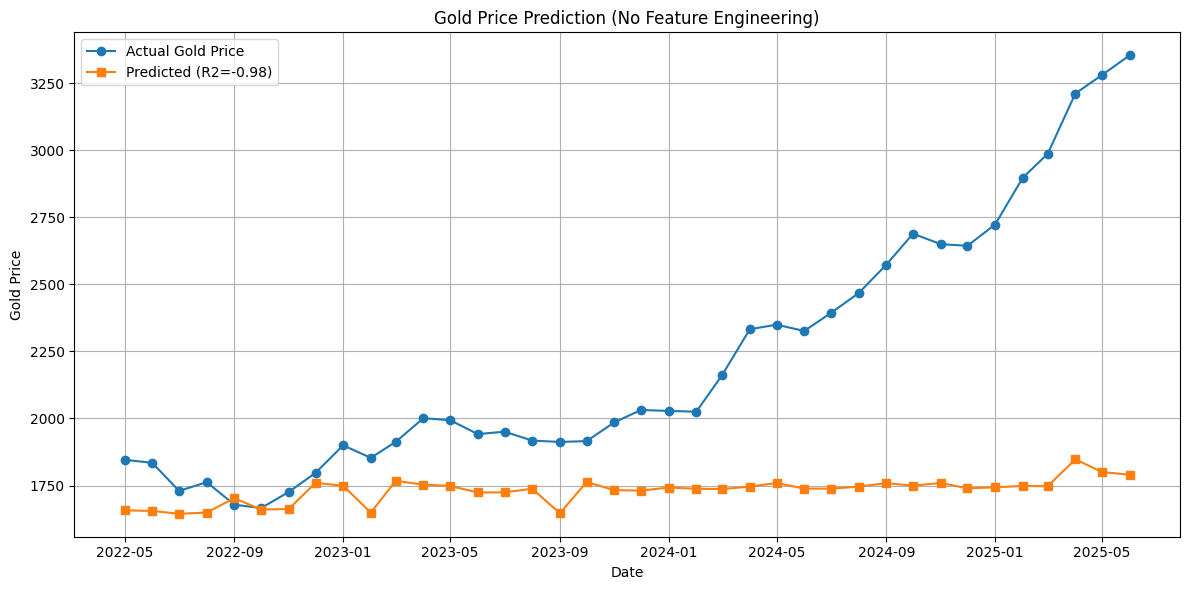

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from xgboost import XGBRegressor

# ==============================
# 1. 데이터 준비 (피처 엔지니어링 없이)
# ==============================
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

# Features & Target
# Gold_Price와 날짜 관련 열만 제외
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date"])
y = df["Gold_Price"]

# 학습용 데이터와 테스트용 데이터 분할 (예: 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# ==============================
# 2. Optuna Objective 정의
# ==============================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBRegressor(**params))
    ])

    # TimeSeriesSplit 교차 검증
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        pipeline.fit(X_train_cv, y_train_cv)
        y_pred = pipeline.predict(X_val_cv)
        scores.append(r2_score(y_val_cv, y_pred))

    return np.mean(scores)

# ==============================
# 3. Optuna 실행
# ==============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) # n_trials 조정 가능
print("Best Params:", study.best_params)
print("Best R2:", study.best_value)

# ==============================
# 4. 최적 하이퍼파라미터로 최종 학습
# ==============================
best_params = study.best_params
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(**best_params))
])
final_model.fit(X_train, y_train)

# ==============================
# 5. 테스트셋 예측 및 성능 평가
# ==============================
y_pred_price = final_model.predict(X_test)

r2 = r2_score(y_test, y_pred_price)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_price))
mae = mean_absolute_error(y_test, y_pred_price)
print(f"Test R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ==============================
# 6. 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test, label="Actual Gold Price", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted (R2={r2:.2f})", marker='s')
plt.title("Gold Price Prediction (No Feature Engineering)")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**하이퍼 파라미터 튜닝X(기본 XGB)**

Test R2: -0.9286, RMSE: 649.87, MAE: 481.80


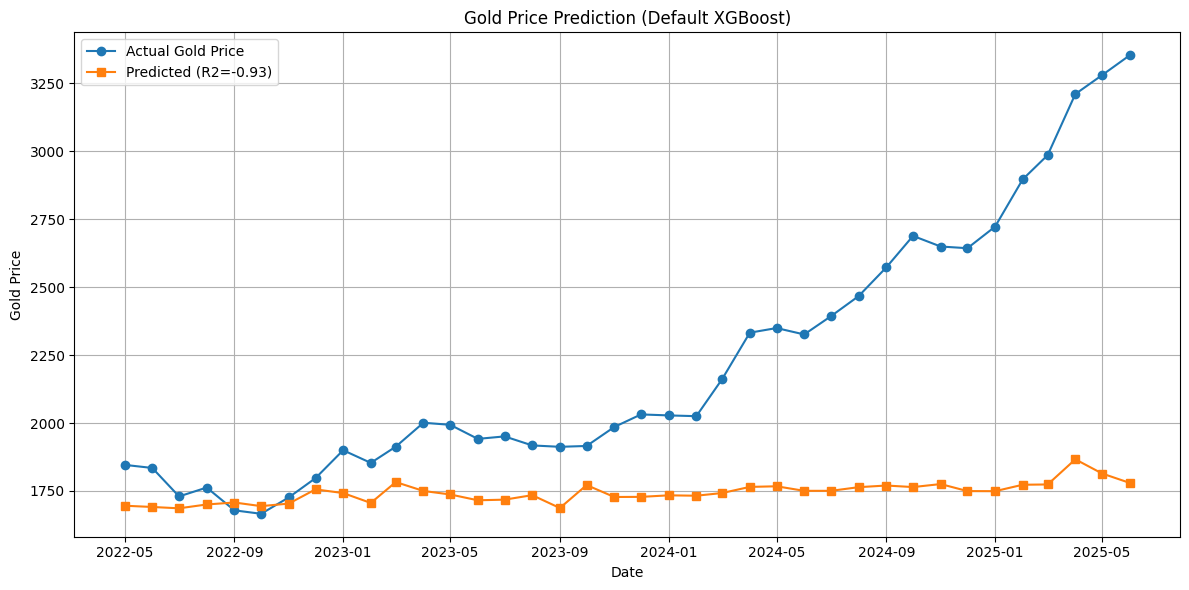

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# ==============================
# 1. 데이터 준비
# ==============================
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

# Features & Target
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date"])
y = df["Gold_Price"]

# 데이터 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# ==============================
# 2. 모델 생성 및 학습
# ==============================
# Pipeline을 사용하여 스케일링과 모델 학습을 한번에 처리
# XGBRegressor()에 아무런 인자를 주지 않으면 기본 하이퍼파라미터로 작동합니다.
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(random_state=42))
])

# 모델 학습
pipeline.fit(X_train, y_train)


# ==============================
# 3. 예측 및 성능 평가
# ==============================
y_pred_price = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred_price)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_price))
mae = mean_absolute_error(y_test, y_pred_price)
print(f"Test R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


# ==============================
# 4. 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test, label="Actual Gold Price", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted (R2={r2:.2f})", marker='s')
plt.title("Gold Price Prediction (Default XGBoost)")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**OPTUNA X / 피처엔지니어링 O**

Test R2: 0.9826, RMSE: 61.94, MAE: 47.48


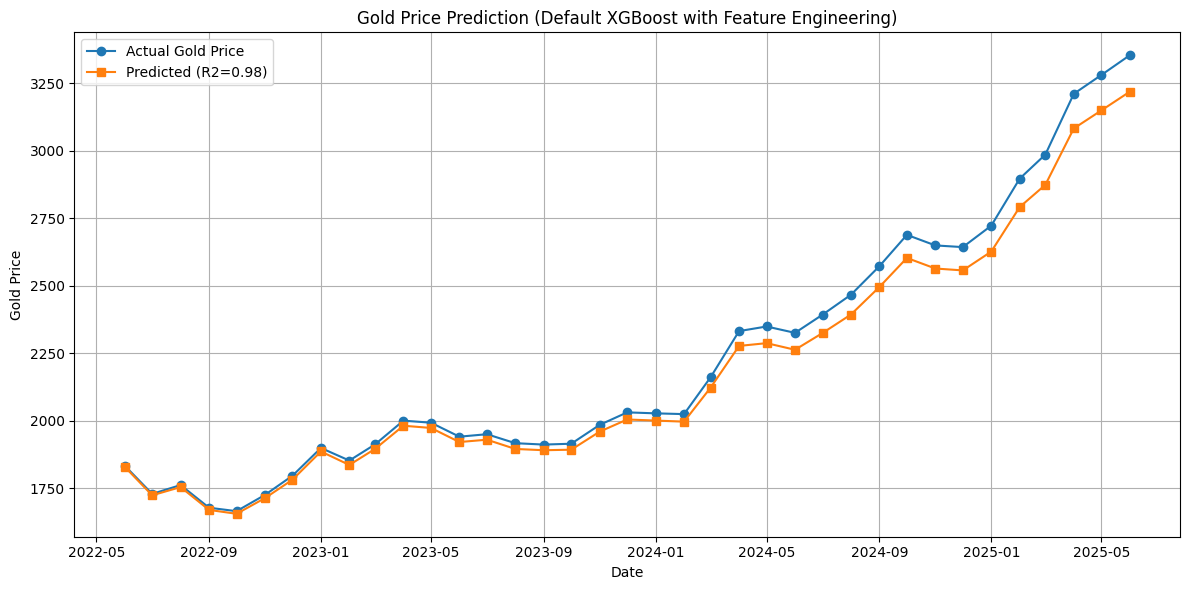

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# ==============================
# 1. 데이터 준비 및 피처 엔지니어링
# ==============================
df = pd.read_csv('gold_data_raw_combined.csv')
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

# Feature Engineering
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['gold_lag1'] = df['Gold_Price'].shift(1)
df['gold_lag3'] = df['Gold_Price'].shift(3)
df['gold_roll3'] = df['Gold_Price'].rolling(3).mean()
df['gold_return'] = df['Gold_Price'].pct_change()
df['m2_growth'] = df['US_M2_Money_Supply'].pct_change()
df['cpi_inflation'] = df['US_CPI'].pct_change()
df['gold_log'] = np.log(df['Gold_Price'])
df['gold_log_diff1'] = df['gold_log'].diff(1)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df = df.dropna().reset_index(drop=True)

# Features & Target (로그 차분 값을 예측)
X = df.drop(columns=["Gold_Price", "Date_YYYY_MM", "Date", "gold_log", "gold_log_diff1"])
y = df["gold_log_diff1"]

# 데이터 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# ==============================
# 2. 기본 모델 생성 및 학습
# ==============================
# Pipeline을 사용하여 스케일링과 모델 학습을 한번에 처리
# XGBRegressor()에 random_state만 지정하여 기본 하이퍼파라미터로 작동
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(random_state=42))
])

# 모델 학습
pipeline.fit(X_train, y_train)


# ==============================
# 3. 예측 및 가격 복원
# ==============================
# 1. 로그 차분 값 예측
y_pred_diff = pipeline.predict(X_test)

# 2. 원래 가격으로 복원
# 테스트 시작 직전의 마지막 로그 가격을 기준점으로 사용
last_log_price = df.loc[y_test.index[0] - 1, "gold_log"]

# 예측된 차분값을 누적 합산하여 로그 가격으로 복원
y_pred_log = np.cumsum(y_pred_diff) + last_log_price

# 로그 가격을 지수 변환하여 최종 가격으로 복원
y_pred_price = np.exp(y_pred_log)

# 비교를 위한 실제 가격
y_test_price = df.loc[y_test.index, "Gold_Price"]


# ==============================
# 4. 성능 평가 (복원된 가격 기준)
# ==============================
r2 = r2_score(y_test_price, y_pred_price)
rmse = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
mae = mean_absolute_error(y_test_price, y_pred_price)
print(f"Test R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


# ==============================
# 5. 시각화
# ==============================
plt.figure(figsize=(12,6))
plt.plot(df.loc[y_test.index, "Date"], y_test_price.values, label="Actual Gold Price", marker='o')
plt.plot(df.loc[y_test.index, "Date"], y_pred_price, label=f"Predicted (R2={r2:.2f})", marker='s')
plt.title("Gold Price Prediction (Default XGBoost with Feature Engineering)")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()